In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from fastai.vision.all import *
from PIL import Image
import os
import shutil
import pathlib
import torch
from os import listdir
from os.path import isfile, join

In [3]:
# load the segmentation masks (in run-length encoding format)
masks_rle = pd.read_csv('../airbus_dataset/train_ship_segmentations_v2.csv').set_index('ImageId')

# select the names of images that have a ship
# 
# images that have a ship have str as the type of EncodedPixels, while images that 
# do not have a ship have float as the type of EncodedPixels
# 
# reference for lambda function: https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
ship_images = masks_rle[masks_rle['EncodedPixels'].apply(lambda x: isinstance(x, str))].index.unique().tolist()
print('Number of images with ships:', len(ship_images))

Number of images with ships: 42556


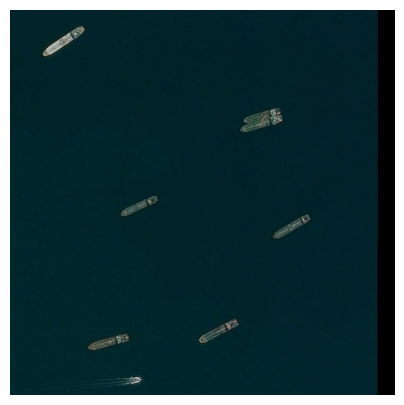

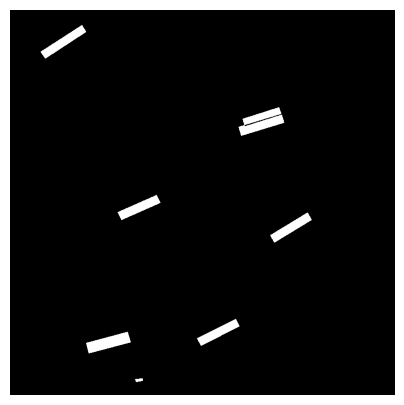

In [4]:
# generate the full image mask of an image from run-length encoding
def get_image_mask(image_id):
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
        mask = mask.split()
        mask = [int(i) for i in mask]
        for i in range(0, len(mask), 2):
            image_mask[mask[i]:mask[i]+mask[i+1]] = 1

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

img_id = '0e9014ce4.jpg'
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(np.array(Image.open('../airbus_dataset/train_valid/' + img_id)))
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(get_image_mask(img_id), cmap='Greys_r')


In [5]:
# save all the masks (targets) as png files
#   path - folder in which to save the images
#   images - images for which to save masks
def save_masks_png(path, images):

    # loop through all images that have at least a ship
    for image in images:

        # check that the image contains a ship
        if image in ship_images:

            # get the corresponding mask as numpy array
            mask = get_image_mask(image)
            mask_img = Image.fromarray(mask).convert('RGB')
            mask_img.save(path + image[:-4] + '_P.png')

# save_masks_png('../airbus_dataset/train_v2_labels/', ship_images)

# check how many files are in the labels directory
c = 0
for file in os.listdir('../airbus_dataset/train_v2_labels/'):
    c += 1
print('Number of labels:', c)

Number of labels: 42556


In [5]:
# split the data into train, validation and test
# only use images that contain at least one ship
# 
#   train: 30K images
#   validation: 6K images
#   test: approx. 6K (rest of images with ships in them)
# 
# the sets will contain image ids

# first split into train + validation and test
train_validation_data, test_data = train_test_split(ship_images, train_size=36000)

# further split into train and validation
train_data, validation_data = train_test_split(train_validation_data, train_size=30000)

print('Images in training dataset:', len(train_data))
print('Images in validation dataset:', len(validation_data))
print('Images in test dataset:', len(test_data))

# need to copy all images in the train + validation subset to another folder,
# in order to use the fast.ai functions to create a datablock

# remove all files currently in the train_valid folder
# for file in os.listdir('../airbus_dataset/train_valid'):
#     os.remove('../airbus_dataset/train_valid/' + file)

# # copy all files in the train + validation subset to the train_valid subfolder
# for file in train_validation_data:
#     src = '../airbus_dataset/train_v2/' + file
#     dst = '../airbus_dataset/train_valid/' + file
#     shutil.copy(src, dst)

# print the number of files in the train_valid folder
c = 0
for file in os.listdir('../airbus_dataset/train_valid/'):
    c += 1
print('\nNumber of training and validation images:', c)

Images in training dataset: 30000
Images in validation dataset: 6000
Images in test dataset: 6556

Number of training and validation images: 36000


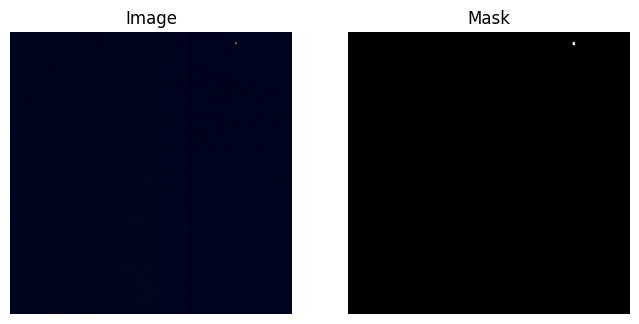

In [11]:
# get the path of the current working directory
path = pathlib.Path().resolve()

# define a function that gets the label for a given image
def label_func(fn): return path/"../airbus_dataset/train_v2_labels"/f"{fn.stem}_P.png"

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(path/'../airbus_dataset'/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(), # splits data into training and validation (0.2 for validation)
    item_tfms=Resize(224) # resize images to 224x224
)

# create a dataset from the datablock
dsets = dblock.datasets(path/'../airbus_dataset/train_valid/')

# show an example of training image and its corresponding mask
fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(dsets.train[0][0])
plt.axis('off')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.imshow(dsets.train[0][1], cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

In [12]:
# create a dataloader
dls = dblock.dataloaders(path/'../airbus_dataset/train_valid/', bs=4, device=torch.device('cuda'))
dls.show_batch()

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [9]:
# create a unet learner
learn = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

learn.summary()

/home/stefan/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stefan/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicUnet (Input shape: 4 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 192 x 56 x 56   
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     4 x 192 x 28 x 28   
MaxPool2d                                   

In [10]:
import os
# torch.cuda.init()
# os.environ['CUDA_VISIBLE_DEVICES']='2'

### 1st TRAINING PHASE ###
# freeze encoder
# one cycle policy
# lr = 1e-4
# 3 epochs
learn.fit_one_cycle(3)

### 2nd TRAINING PHASE ###
# unfreeze encoder
# 4 more epochs
# other hyperparameters are the same
learn.unfreeze()
learn.fit_one_cycle(4)

# same the model
print('Saving model...')
learn.save('unet_googlenet')
print('Saved model!')

epoch,train_loss,valid_loss,time
0,0.001634,0.001611,1:18:34
1,0.001083,0.001089,1:18:35
2,0.000780,0.001021,1:18:37


epoch,train_loss,valid_loss,time
0,0.000919,0.001129,1:19:23
1,0.000749,0.000941,1:19:21
2,0.000603,0.000825,1:19:22
3,0.000572,0.000842,1:19:15


Saving model...
Saved model!


In [2]:
test1 = torch.rand(10000, 10000).to(torch.device('cuda'))
test2 = torch.rand(10000, 10000).cuda()


print(test1 * test2)

tensor([[1.4173e-01, 2.2493e-01, 1.2523e-01,  ..., 1.0282e-01, 5.2913e-01,
         8.5772e-02],
        [3.1682e-01, 5.1293e-01, 2.3525e-01,  ..., 2.4901e-04, 2.8492e-01,
         3.8503e-01],
        [3.0999e-01, 2.8160e-01, 4.0006e-01,  ..., 2.6687e-01, 1.5210e-01,
         5.0441e-01],
        ...,
        [2.4372e-01, 6.0122e-01, 6.0169e-02,  ..., 6.9443e-01, 1.2254e-03,
         1.4954e-01],
        [2.1795e-01, 3.0959e-02, 2.3738e-01,  ..., 7.3732e-01, 6.6558e-01,
         7.7859e-01],
        [8.1979e-02, 1.1424e-01, 4.1048e-01,  ..., 1.8092e-01, 1.0885e-01,
         2.0243e-01]], device='cuda:0')


## Generate the list of the images that are used for testing

In [9]:
images_used_for_training = [f for f in listdir('../airbus_dataset/train_valid/') if isfile(join('../airbus_dataset/train_valid/', f))]
images_to_test = list(set(ship_images) - set(images_used_for_training))

print("Number of images to test: " + str(len(images_to_test)))

# remove all files currently in the train_valid folder
# for file in os.listdir('../airbus_dataset/images_to_test'):
#     os.remove('../airbus_dataset/images_to_test/' + file)

# # copy all files in the train + validation subset to the train_valid subfolder
# for file in images_to_test:
#     src = '../airbus_dataset/train_v2/' + file
#     dst = '../airbus_dataset/images_to_test/' + file
#     shutil.copy(src, dst)

# # print the number of files in the train_valid folder
# c = 0
# for file in os.listdir('../airbus_dataset/images_to_test/'):
#     c += 1
# print('\nNumber of test images:', c)


Number of images to test: 6556


In [10]:
# get the path of the current working directory
path = pathlib.Path().resolve()

# define a function that gets the label for a given image
def label_func(fn): return path/"../airbus_dataset/train_v2_labels"/f"{fn.stem}_P.png"

dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(path/'../airbus_dataset'/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(), # splits data into training and validation (0.2 for validation)
    item_tfms=Resize(224) # resize images to 224x224
)

dls = dblock.dataloaders(path/'../airbus_dataset/images_to_test/', bs=4, device=torch.device('cuda'))
dls.show_batch()

testLearn = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

testLearn.load('unet_googlenet')

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Prepare the testing dataset - run to recreate the images_to_test folder (not recomended)

In [20]:
def get_image_mask_coloured(image_id):
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
        mask = mask.split()
        mask = [int(i) for i in mask]
        for i in range(0, len(mask), 2):
            image_mask[mask[i]:mask[i]+mask[i+1]] = 255

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

def save_masks_png_coloured(path, images):

    # loop through all images that have at least a ship
    for image in images:

        # check that the image contains a ship
        if image in ship_images:

            # get the corresponding mask as numpy array
            mask = get_image_mask_coloured(image)
            mask_img = Image.fromarray(mask).convert('RGB')
            mask_img.save(path + image[:-4] + '_P.png')

for file in os.listdir('../airbus_dataset/images_to_test_labels'):
    os.remove('../airbus_dataset/images_to_test_labels/' + file)
    
save_masks_png_coloured('../airbus_dataset/images_to_test_labels/', images_to_test)

## Run the testings

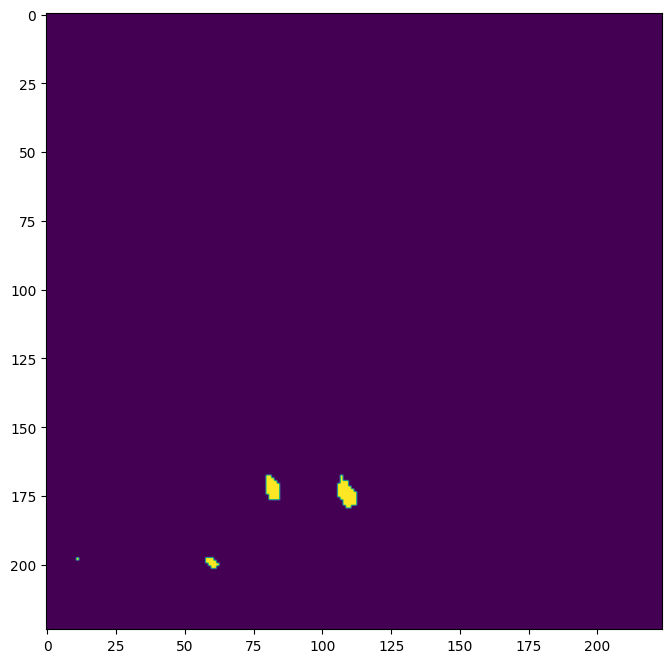

In [33]:
from scipy import ndimage
import skimage
import numpy

tp = 0
fn = 0
fp = 0
treshold = 0.7

# image = '0bf71b165.jpg'
for image in images_to_test:
    with testLearn.no_bar(), testLearn.no_logging(): _, _, outputs = testLearn.predict('../airbus_dataset/images_to_test/' + image)

    # cureate the image from unnecesary values ie values that have negative values and replace with 0, else with 255
    # as long as we increase the value from k to 255, the masks edges less soft
    curated_output = outputs.numpy()[1]
    for pixel in enumerate(curated_output):
        curated_output[pixel[0]] = [(k >= 0) * 1 for k in curated_output[pixel[0]]]

    # we create now the ground truth value (or the labeled image to check) and we reseize it to 244, 244 the size of the curated_output produced by the unet
    ground_truth_labeled_image = Image.open('../airbus_dataset/images_to_test_labels/' + image.split('.')[0] + '_P.png')
    groud_truth_value = numpy.asarray(ground_truth_labeled_image.resize(size=(224, 224)))

    # merge each pixel intro 0 or 1 probability that a ship should be there
    ground_truth_value_curated = np.zeros((groud_truth_value.shape[0], groud_truth_value.shape[1]))
    for pixel in enumerate(groud_truth_value):
        ground_truth_value_curated[pixel[0]] = [(k[0] != 0) * 1 for k in groud_truth_value[pixel[0]]]

    labels, nlabels = skimage.measure.label(curated_output > 0.9, connectivity = 2, return_num = True)
    ground_truth_labels, ground_truth_nlabels = skimage.measure.label(ground_truth_value_curated > 0.9, connectivity = 2, return_num = True)
    matched = np.empty(nlabels)
    matched.fill(0)

    for ground_truth_identificator in range(ground_truth_nlabels):
        ground_truth_tmp_image = ground_truth_labels.copy() 
        ground_truth_tmp_image[ground_truth_tmp_image != (ground_truth_identificator + 1)] = 0
        found = False

        for identificator in range(nlabels):
            tmp_image = labels.copy() 
            tmp_image[tmp_image != (identificator + 1)] = 0

            intersection = numpy.logical_and(tmp_image, ground_truth_tmp_image)
            union = numpy.logical_or(tmp_image, ground_truth_tmp_image)
            iou_score = numpy.sum(intersection) / numpy.sum(union)
            
            if iou_score > treshold and not matched[identificator] == 1:
                tp += 1
                found = True
                matched[identificator] = 1
                break

        if not found:
            fn += 1

    for identificator in range(nlabels):
        if not matched[identificator] == 1:
            fp += 1

In [34]:
print('True positive: ' + str(tp))
print('False positive: ' + str(fp))
print('False negative: ' + str(fn))

True positive: 0
False positive: 4
False negative: 2


In [17]:
precision = tp /  (tp + fp)
recall = tp /  (tp + fn)
F1Score = 2 * (precision * recall) / (precision + recall)

print(precision)
print(recall)
print(F1Score)

0.4719484827788077
0.44109064380813423
0.4559981145415979
